# Vectorization and Topic Modeling

In this notebook, I build a custom tf-idf vectorizer to handle our preprocessed and tokenized data. I then use Latent Semantic Analysis (LSA) to generate topic loadings.

## Import modules and data

In [2]:
import pandas as pd
import numpy as np
import spacy
import textacy
import pickle
import time
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD

In [33]:
with open('../data/tokenized_rest_reviews.pkl', 'rb') as f:
    rests = pickle.load(f)

In [2]:
with open('../data/tokenized_bs_reviews.pkl', 'rb') as b:
    bus = pickle.load(b)

## Build the custom tf-idf vectorizer

Scikit-learn's tf-idf vectorizer by default is implemented as a three component function, containing an analyzer, tokenizer and a preprocessor. Due to this three component structure, I will need to construct a custom vectorizer using the tf-idf framework that takes into account that our data is already processed and tokenized. We use the `identity` function to tell the vectorizer to not modify the text in the tokenizer and preprocessor stages.

In [3]:
def identity(doc):
    return doc

In [4]:
vectorizer = TfidfVectorizer(analyzer='word', tokenizer=identity, preprocessor=identity, 
                             token_pattern=None, strip_accents='ascii', min_df=5, max_df=0.95,
                             max_features=10000, use_idf=True, sublinear_tf=True)

## Create tf-idf document-term matrices

### Restaurants

In [34]:
doc_term_matrix = vectorizer.fit_transform((doc for doc in rests))

### Businesses

In [5]:
doc_term_matrix = vectorizer.fit_transform((doc for doc in bus))

## Topic Modeling

I compared the topic generation of two topic modeling strategies: Latent Semantic Analysis (LSA) and non-Negative Matrix Factorization (NMF) on the restaurant review dataset. 

Research ([**Blei et. al (2003)**](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf), [**Stevens et. al (2012)**](http://aclweb.org/anthology/D/D12/D12-1087.pdf) suggests that the most important characteristic of topics used in text classification to improve accuracy is the *quality* of topics rather than coherence; thus we should choose the topic modeling that gives the most topics relevant to the text space.

While both NMF and LSA could be fit on an AWS t2.2xlarge instance, topics generated by NMF were heavily weighted toward the primary term for each topic whereas the topics generated by LSA cover a greater breadth of terms with topic weights varying throughout the set of topics. LSA was chosen due to its much faster fit time, increased term coverage per topic, and potential for expansion. 

The two below functions are used to visually inspect topics and the top documents in each corpus for the topics created by our models.

In [6]:
def print_topics(model, n_topics, n_terms):
    for topic_idx, top_terms in model.top_topic_terms(vectorizer.get_feature_names(), topics=n_topics, top_n=n_terms):
        print('topic', topic_idx, ':', '   '.join(top_terms))

In [7]:
def top_topic_docs(corpus, model, doc_topic_matrix, n_topics):
    for topic_idx, top_docs in model.top_topic_docs(doc_topic_matrix, topics=n_topics, top_n=1):
        print(topic_idx)
        for j in top_docs:
            print(corpus[j])

## LSA - Restaurants

Only 200 topics from the restaurant reviews could be included due to memory limitations.

### Plot explained variance

Assessing the percentage of variance explained by the results of topic modeling should aid in selecting the number of topics to be used in classification.

In [69]:
%%time
lsa_model = TruncatedSVD(n_components=200, random_state=1)
lsa_model.fit(doc_term_matrix)

CPU times: user 11min 48s, sys: 2min 20s, total: 14min 8s
Wall time: 7min 37s


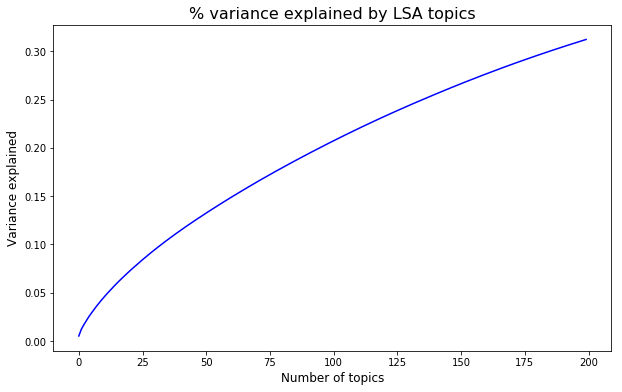

In [70]:
plt.figure(figsize=(10, 6))
plt.plot(range(200), np.cumsum(lsa_model.explained_variance_ratio_), color='blue')
plt.title('% variance explained by LSA topics', size=16)
plt.xlabel('Number of topics', size=12)
plt.ylabel('Variance explained', size=12)
plt.savefig('../visuals/LSA_rests_var.png')

We can see that adding more topics should improve the percentage of variance explained; with increased compute power we could add more topics until a noticeable elbow or plateau appears on this graph.

### Show topics and create termite plots

Termite plots show topics on the x-axis and terms on the y-axis, with larger circles signifying stronger weight of the term to for the corresponding topic. 

In [60]:
%%time
lsa_model = textacy.TopicModel('lsa', n_topics=200, random_state=1)
lsa_model.fit(doc_term_matrix)

lsa_doc_topic_matrix = lsa_model.transform(doc_term_matrix)

CPU times: user 12min 8s, sys: 2min 20s, total: 14min 28s
Wall time: 7min 56s


In [18]:
print_topics(lsa_model, n_topics=[num for num in range(1, 20)], n_terms=5)

topic 1 : great   service   friendly   place   amaze
topic 2 : chicken   fry   with   sauce   delicious
topic 3 : pizza   place   this   always   they
topic 4 : pizza   great   service   order   numb
topic 5 : great   numb   price   service   lunch
topic 6 : very   friendly   staff   sushi   price
topic 7 : always   they   staff   friendly   have
topic 8 : staff   friendly   very   place   burger
topic 9 : numb   chicken   fry   place   burger
topic 10 : back   will   price   burger   definitely
topic 11 : numb   breakfast   here   definitely   amaze
topic 12 : burger   fry   burgers   amaze   here
topic 13 : sushi   great   roll   staff   fresh
topic 14 : here   chicken   be   drink   night
topic 15 : they   their   have   tacos   amaze
topic 16 : amaze   staff   much   friendly   chicken
topic 17 : recommend   really   would   highly   friendly
topic 18 : amaze   really   service   very   breakfast
topic 19 : always   really   delicious   service   their


From the above 20 topics, we can see that LSA does not necessarily aggregate topics under one primary term, but does a good job at creating similar topics that encapsulate the variation of documents speaking to similar subjects:

|          Topic         	|                                                                                                                                                                                                                             Terms                                                                                                                                                                                                                             	|
|:----------------------:	|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------:	|
| **Good service/staff** 	| **Topic 1** : great   service   friendly   place   amaze<br> **Topic 5** : great   numb   price   service   lunch<br> **Topic 6** : very   friendly   staff   sushi   price<br> **Topic 7** : always   they   staff   friendly   have<br> **Topic 8** : staff   friendly   very   place   burger<br> **Topic 16** : amaze   staff   much   friendly   chicken<br> **Topic 18** : amaze   really   service   very   breakfast<br> **Topic 19** : always   really   delicious   service   their 	|
|        **Pizza**       	| **Topic 3** : pizza   place   this   always   they<br> **Topic 4** : pizza   great   service   order   numb                                                                                                                                                                                                                                                                                                                                                           	|
|   **Recommendation**   	| **Topic 17** : recommend   really   would   highly   friendly                                                                                                                                                                                                                                                                                                                                                                                                     	|
|        **Sushi**       	| **Topic 13** : sushi   great   roll   staff   fresh                                                                                                                                                                                                                                                                                                                                                                                                               	|
|    **Fried Chicken**   	| **Topic 2** : chicken   fry   with   sauce   delicious<br> **Topic 9** : numb   chicken   fry   place   burger                                                                                                                                                                                                                                                                                                                                                        	|
|        **Tacos**       	| **Topic 15** : they   their   have   tacos   amaze                                                                                                                                                                                                                                                                                                                                                                                                                	|
|       **Burgers**      	| **Topic 10** : back   will   price   burger   definitely<br> **Topic 12** : burger   fry   burgers   amaze   here                                                                                                                                                                                                                                                                                                                                                     	|
|      **Breakfast**     	| **Topic 11** : numb   breakfast   here   definitely   amaze                                                                                                                                                                                                                                                                                                                                                                                                       	|
|     **Bars/Wings**     	| **Topic 14** : here   chicken   be   drink   night                                                                                                                                                                                                                                                                                                                                                                                                                	|

/opt/conda/lib/python3.6/site-packages/matplotlib/collections.py:877: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


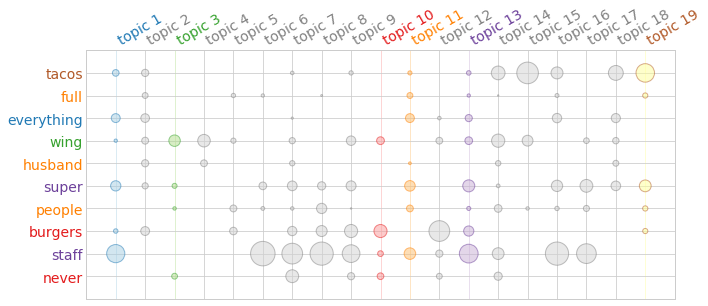

In [61]:
lsa_model.termite_plot(doc_term_matrix,
                       vectorizer.get_feature_names(), 
                       topics=[num for num in range(1, 20)],
                       n_terms=10, 
                       highlight_topics=[1, 3, 10, 11, 13, 19],
                       save='../visuals/business_termite_plot.png')

Comparing the termite plot to the above table, we can see that 'staff' was an important term in 8 topics (1, 5, 6, 7, 9, 13, 16, 17). 

Highlighting individual topics also highlights terms on the y-axis in which the selected topic had the strongest weight for a term compared to other highlighted topics.

In [19]:
np.save('../data/rests_dt_matrix.npy', lsa_doc_topic_matrix)

## LSA - Businesses

Due to memory limitations, only 325 topics could be included in the final topic model.

### Plot explained variance

In [8]:
%%time
lsa_model_bs = TruncatedSVD(n_components=325, random_state=1)
lsa_model_bs.fit(doc_term_matrix)

CPU times: user 12min 16s, sys: 2min 38s, total: 14min 55s
Wall time: 7min 47s


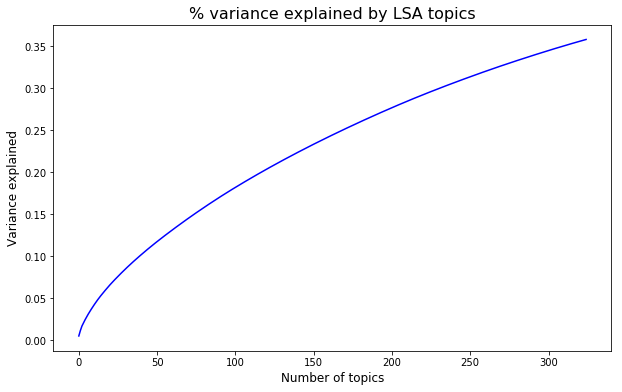

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(range(325), np.cumsum(lsa_model_bs.explained_variance_ratio_), color='blue')
plt.title('% variance explained by LSA topics', size=16)
plt.xlabel('Number of topics', size=12)
plt.ylabel('Variance explained', size=12)
plt.savefig('../visuals/LSA_bus_var.png')

We can see that the amount of cumulative explained variance continuously increases as we add topics.

### Show topics and create termite plot

In [12]:
lsa_model_bs = textacy.TopicModel('lsa', n_topics=325, random_state=1)
lsa_model_bs.fit(doc_term_matrix)
lsa_dt_matrix_bs = lsa_model_bs.transform(doc_term_matrix)

/opt/conda/lib/python3.6/site-packages/matplotlib/collections.py:877: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


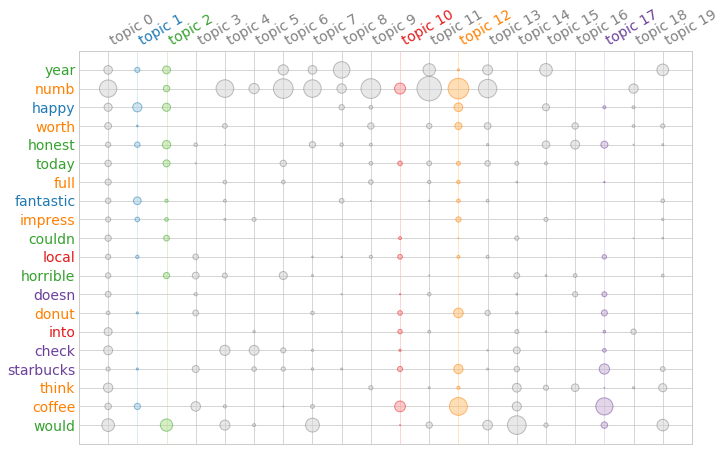

In [26]:
lsa_model_bs.termite_plot(doc_term_matrix, 
                          vectorizer.get_feature_names(), 
                          topics=[num for num in range(20)],
                          highlight_topics=[1, 2, 10, 12, 17],
                          n_terms=20,
                          save='../visuals/business_termite.png')

In [20]:
print_topics(lsa_model_bs, n_topics=range(20), n_terms=5)

topic 0 : they   numb   this   that   have
topic 1 : great   very   friendly   staff   recommend
topic 2 : service   call   recommend   them   customer
topic 3 : service   customer   store   they   price
topic 4 : service   great   hotel   numb   vega
topic 5 : staff   very   friendly   helpful   clean
topic 6 : numb   here   nail   staff   friendly
topic 7 : recommend   place   they   highly   numb
topic 8 : always   great   have   year   be
topic 9 : great   price   numb   they   nail
topic 10 : great   staff   place   call   office
topic 11 : numb   store   recommend   highly   minute
topic 12 : numb   coffee   service   drink   very
topic 13 : here   will   definitely   back   numb
topic 14 : recommend   would   highly   there   great
topic 15 : very   here   be   place   there
topic 16 : your   price   here   much   staff
topic 17 : always   coffee   call   price   clean
topic 18 : show   always   there   amaze   awesome
topic 19 : much   than   show   be   friendly


Many of the example topics (1-6, 10, 16, 19) revolve around great service or staff. Some are business specific (topic 6 seems to be related to nail salons, topic 12 is about coffee shops). Overall, we see that LSA is producing relatively understandable topics, but does not aggregate topics under one heavily weighted term.

In [29]:
np.save('../data/business_doc_topic_matrix.npy', lsa_dt_matrix_bs)

## NMF

The below code visually shows how topics generated by NMF are heavily focused on single terms and thus a term would not have weights in topics other than those where the term was the primary or secondary term.

In [22]:
%%time
nmf_model = textacy.TopicModel('nmf', n_topics=50, n_jobs=-1)
nmf_model.fit(doc_term_matrix)

CPU times: user 1h 29min 46s, sys: 3min 6s, total: 1h 32min 53s
Wall time: 1h 28min 27s


In [23]:
doc_topic_matrix_nmf = nmf_model.transform(doc_term_matrix)

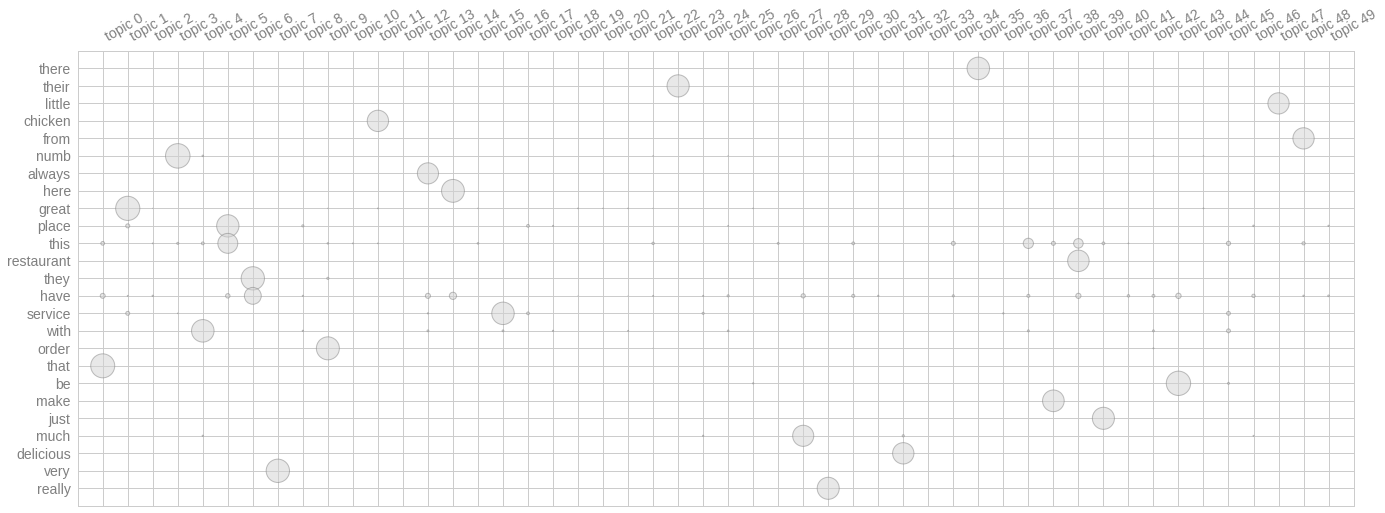

In [25]:
nmf_model.termite_plot(doc_term_matrix, vectorizer.get_feature_names(), topics=[num for num in range(0, 50, 1)])